## Step 1: Importing the Necessary Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

## Step 2: Load and Filter Data for Karnataka

In [41]:
df = pd.read_csv('clustering_data.csv', dtype={9: str})

homeState = 'KARNATAKA'
dfHomeState = df[df['StateName'] == homeState].copy()

## Step 3: Data Pre-Processing

In [42]:
# clean Latitude and Longitude columns
dfHomeState['Latitude'] = pd.to_numeric(dfHomeState['Latitude'].astype(str).str.strip('-').str.strip(), errors='coerce')
dfHomeState['Longitude'] = pd.to_numeric(dfHomeState['Longitude'].astype(str).str.strip('-').str.strip(), errors='coerce')

# after plotting data initially, realised that there are a few latitudes and longitudes misclassified as karnataka
# therefore, using a basic rectangular box to filter out outliers:
minLat = 11.55
maxLat = 18.6
minLong = 74.0
maxLong = 78.7
dfHomeState = dfHomeState[(dfHomeState['Latitude']<maxLat) & (dfHomeState['Latitude']>minLat) & (dfHomeState['Longitude']<maxLong) & (dfHomeState['Longitude']>minLong)]


# drop rows with either of Lat or Long or PinCode = NA
dfHomeState.dropna(subset=['Latitude', 'Longitude', 'Pincode'], inplace=True)

# drop complete row duplicates
dfHomeState.drop_duplicates(inplace=True)

# preparing the data for clustering
data = dfHomeState[['Latitude', 'Longitude']].to_numpy()
data = data.astype(float)
print(data.shape)

(8338, 2)


## Step 4: Plotting the Pincodes on a Map

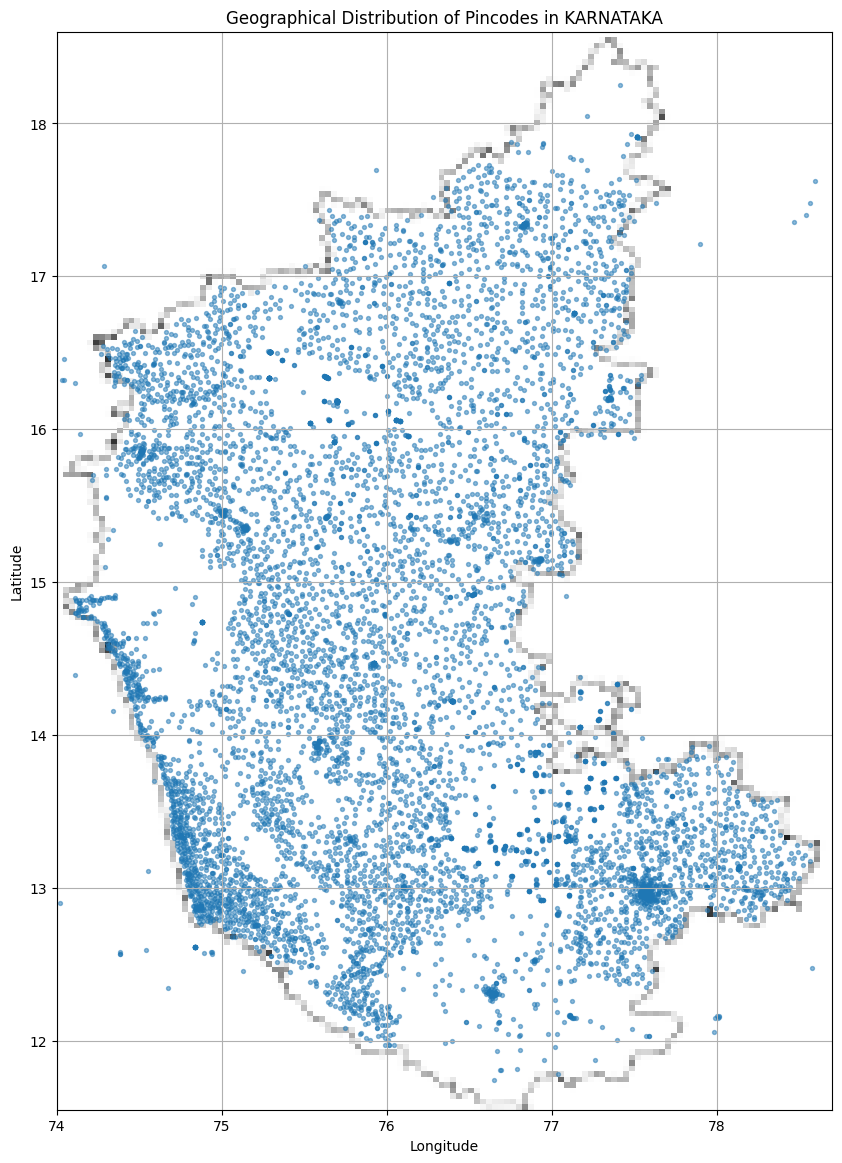

In [43]:
# load map image
img = mpimg.imread('karnataka_map.png')

extent = [minLong, maxLong, minLat, maxLat]

plt.figure(figsize=(10, 14))
plt.imshow(img, extent=extent, aspect='auto')
plt.scatter(data[:,1], data[:,0], alpha=0.5, s=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Geographical Distribution of Pincodes in {homeState}')
plt.grid(True)
plt.show()

## Step 5: Implementing K-Means from Scratch

In [44]:
# randomly pick k points as initial centroids
def initialize_centroids(points, k):
    indices = np.random.choice(points.shape[0], size=k, replace=False)
    return points[indices]

# assign each point to the closest centroid
def assign_clusters(points, centroids):
    distances = np.linalg.norm(points[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# update centroids to be the mean of all points in each cluster
def update_centroids(points, labels, k):
    new_centroids = []
    for i in range(k):
        cluster_points = points[labels == i]
        if len(cluster_points) == 0:
            # if a cluster ends up empty, reassign a random point
            new_centroids.append(points[np.random.randint(0, len(points))])
        else:
            new_centroids.append(cluster_points.mean(axis=0))
    return np.array(new_centroids)

# the main k-means function combining everything
def kmeans(points, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(points, k)
    for _ in range(max_iters):
        labels = assign_clusters(points, centroids)
        new_centroids = update_centroids(points, labels, k)
        # if centroids don’t change much, we can stop
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return centroids, labels


## Step 6: Run K-means (Initially with k=8)

In [45]:
k = 8
centroids, labels = kmeans(data, k)

## Step 7: Visualise Cluster

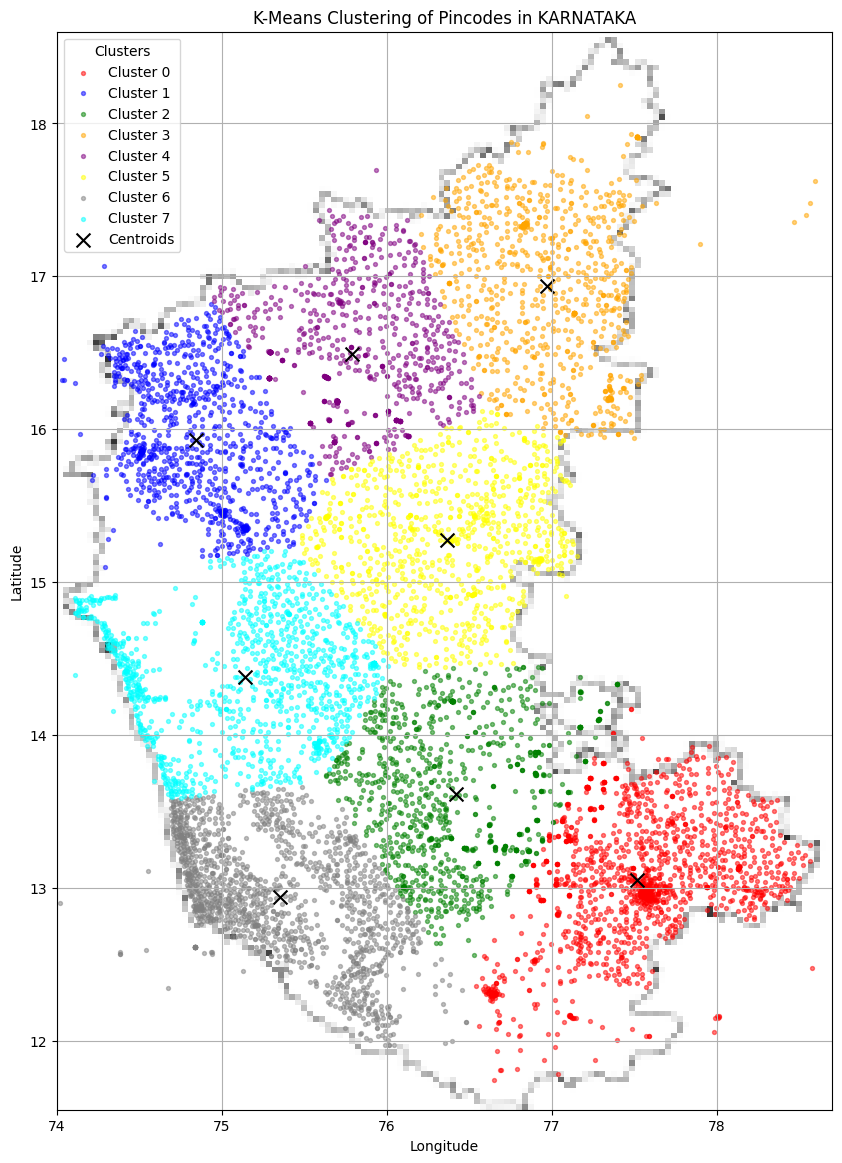

In [46]:
# plotting the clusters on the map

# loading the map image
img = mpimg.imread('karnataka_map.png')
extent = [minLong, maxLong, minLat, maxLat]

plt.figure(figsize=(10, 14))
plt.imshow(img, extent=extent, aspect='auto')

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'gray', 'cyan']

# plot each cluster with its own color
for i in range(k):
    cluster_points = data[labels == i]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], c=colors[i % len(colors)], s=8, alpha=0.5, label=f'Cluster {i}')

# plot the centroids
plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x', s=100, label='Centroids')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'K-Means Clustering of Pincodes in {homeState}')
plt.grid(True)
plt.legend(title="Clusters")
plt.show()


## Step 9: Finding the Optimal Value of k using the Elbow Method

In [47]:
# function to calculate total distance of points to their centroids (WCSS)
def calculate_wcss(data, centroids, labels):
    wcss = 0
    for i, point in enumerate(data):
        centroid = centroids[labels[i]]
        wcss += np.sum((point - centroid) ** 2)
    return wcss

wcss_values = []
K_range = range(1, 11)

# running k-means for different k and storing WCSS for each
for k in K_range:
    centroids, labels = kmeans(data, k)
    wcss = calculate_wcss(data, centroids, labels)
    wcss_values.append(wcss)

### Plotting Elbow Graph

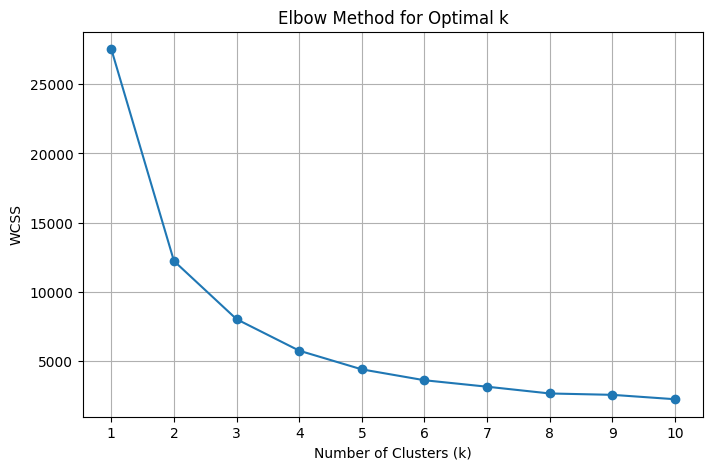

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Although curve has a soft elbow, k=5 seems like a reasonable choice

## Step 10: Re-run K-Means with k=5 and Plot Again

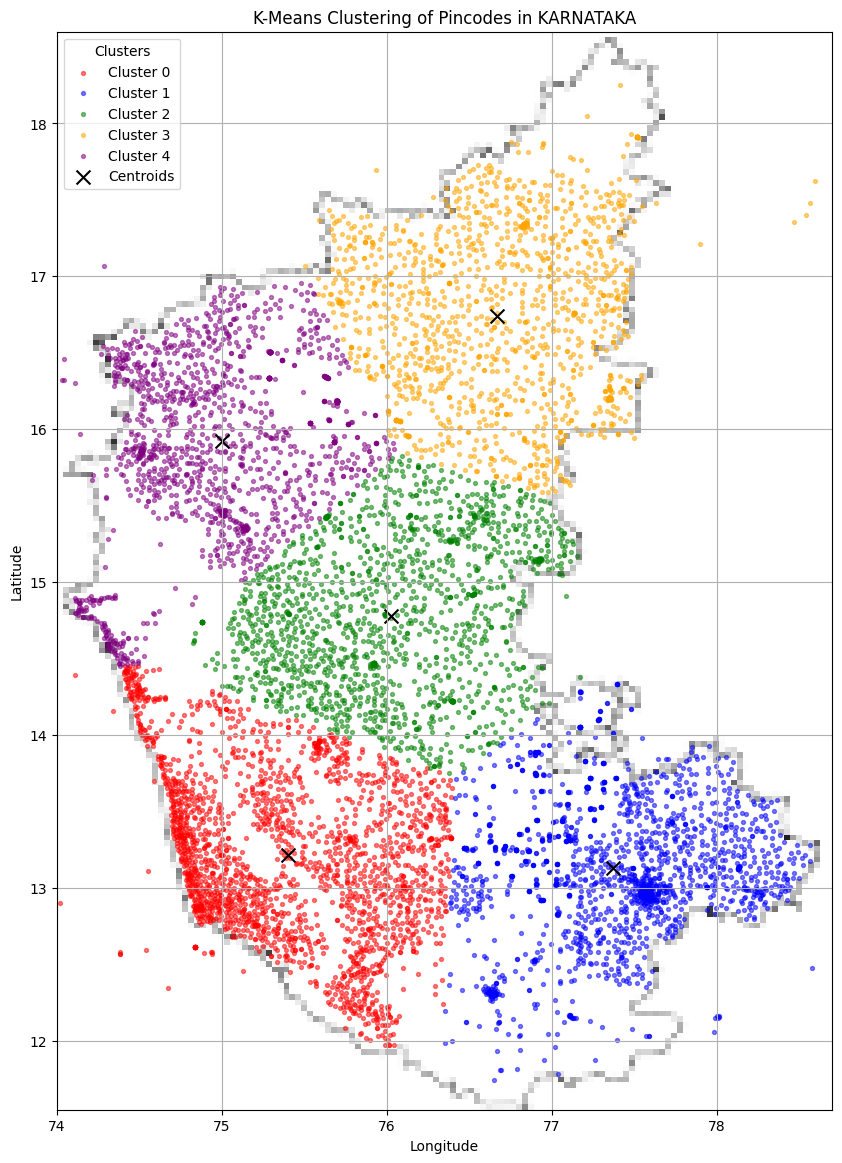

In [49]:
k = 5
centroids, labels = kmeans(data, k)


# load map image
img = mpimg.imread('karnataka_map.png')

extent = [minLong, maxLong, minLat, maxLat]

plt.figure(figsize=(10, 14))
plt.imshow(img, extent=extent, aspect='auto')
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'gray', 'cyan']
for i in range(k):
    cluster_points = data[labels == i]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], c=colors[i % len(colors)], s=8, alpha=0.5, label=f'Cluster {i}')
plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x', s=100, label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'K-Means Clustering of Pincodes in {homeState}')
plt.grid(True)
plt.legend(title="Clusters")
plt.show()

## Step 11: Count of Pincodes per Cluster

<ipython-input-50-bd32101f62b8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette=colors[:k])


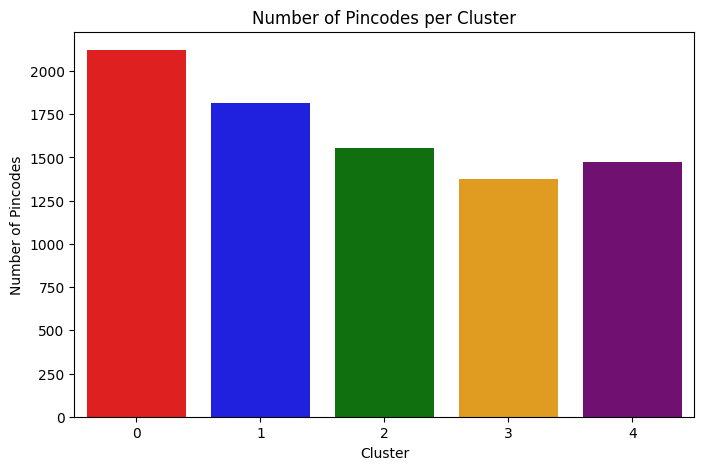

In [50]:
# checking how many pincodes ended up in each cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette=colors[:k])
plt.title('Number of Pincodes per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Pincodes')
plt.show()

This bar graph illustrates that the number of pincode per cluster is directly proportional to the total population that each cluster covers. Also, the more densely populated areas have a larger number of pincodes per cluster even though their size is smaller.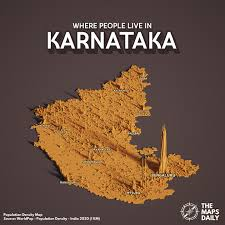